# **Assignment 3 - Text Mining**
## Author: Jake Brulato
## Tuesday 5:30 - 8:15 : Kornelia

**Problem description and questions:  The dataset boo_ratings.csv has reviews of books, along with other information, submitted on Amazon.  The descriptions of the columns are given below.**

- Id: Unique ID for the book 
- Title: Book’s title 
- Price: The price of Book 
- User_id: Unique ID of the user who rates the book 
- profileName: Name of the user who rates the book 
- review/helpfulness: Helpfulness rating (normalized to between 0 and 1) 
- review/score: Rating from 0 to 5 for the book 
- review/time: Time of given review 
- review/summary: The summary of a text review 
- review/text: The full text of a review 

In [39]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim
from gensim import corpora, models
from gensim.similarities import MatrixSimilarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
import pyLDAvis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from scipy.cluster import hierarchy

### **1. (10 pts) Preprocess the text data in each of the "review/summary" and "review/text" columns. Preprocessing should include tokenization, lowercasing, stop word removal, stemming and any other necessary steps.  Describe each of the above step in the Word document.**

In [40]:
df_JB = pd.read_csv('book_ratings.csv')
df_JB.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1593351348,Wuthering Heights,18.96,AKZ3R4NWFK6ON,"E. Gray ""musiq lovr""",0.142857,5,1260230400,Got this,Got this book version along with Romeo & Julie...
1,1578849209,Natural Atheism,14.04,A384SQPY12385,David B. Pearson,0.950000,5,1135123200,Outstanding Freethought,"Although I've pretty much always been a ""natur..."
2,0613659155,Nights In Rodanthe (Turtleback School & Librar...,19.57,A2GAP7XWBZU8QI,Eric,NaN,4,1065744000,A Decent Novel,The first book I read by Mr. Sparks was 'A Wal...
3,1590594991,Pro Apache Log4j,43.94,A2IAL7V5B0M2LZ,"Wayne Cannon ""Wayne""",1.000000,4,1174176000,Almost identical with excellent on-line material,"This is an excellent reference. However, be aw..."
4,0201328186,"Yellow Fever, Black Goddess: The Coevolution O...",15.27,A14UM7LOF20W6P,Frank,0.666667,3,907200000,Stilted prose,"While the subject of the book is fascinating, ..."


In [41]:
#Calculate the nulls and then drop them
df_JB.isnull().sum()
#vv Comment out below this line to see the total nulls for each column vv
df_JB = df_JB.dropna()
df_JB.info()
print(df_JB.isnull().sum())
df_JB

# df_JB.fillna(0, inplace=True)
# print(df_JB.isnull().sum())
# df_JB


<class 'pandas.core.frame.DataFrame'>
Index: 715 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  715 non-null    object 
 1   Title               715 non-null    object 
 2   Price               715 non-null    float64
 3   User_id             715 non-null    object 
 4   profileName         715 non-null    object 
 5   review/helpfulness  715 non-null    float64
 6   review/score        715 non-null    int64  
 7   review/time         715 non-null    int64  
 8   review/summary      715 non-null    object 
 9   review/text         715 non-null    object 
dtypes: float64(2), int64(2), object(6)
memory usage: 61.4+ KB
Id                    0
Title                 0
Price                 0
User_id               0
profileName           0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: in

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1593351348,Wuthering Heights,18.96,AKZ3R4NWFK6ON,"E. Gray ""musiq lovr""",0.142857,5,1260230400,Got this,Got this book version along with Romeo & Julie...
1,1578849209,Natural Atheism,14.04,A384SQPY12385,David B. Pearson,0.950000,5,1135123200,Outstanding Freethought,"Although I've pretty much always been a ""natur..."
3,1590594991,Pro Apache Log4j,43.94,A2IAL7V5B0M2LZ,"Wayne Cannon ""Wayne""",1.000000,4,1174176000,Almost identical with excellent on-line material,"This is an excellent reference. However, be aw..."
4,0201328186,"Yellow Fever, Black Goddess: The Coevolution O...",15.27,A14UM7LOF20W6P,Frank,0.666667,3,907200000,Stilted prose,"While the subject of the book is fascinating, ..."
5,1550226614,The Death of WCW: WrestleCrap and Figure Four ...,11.99,A3OBW7ZP7B1Y1N,T. VanPool,1.000000,4,1301788800,Made Me a Wrestling Fan,By happenstance I watched a documentary about ...
...,...,...,...,...,...,...,...,...,...,...
993,0965911381,Algebra Survival Guide: A Conversational Guide...,13.57,A7MH1SL28IKFF,"GIJANE ""Loves Labs & cooking.""",0.800000,5,1217894400,Great Review,"This books gives a good, simplified review of ..."
994,0312992416,"Kiss of the Night (Dark-Hunter, Book 5)",7.99,ACEA95FQS1AVP,Jem,1.000000,4,1311292800,solid entry to the series,"I love Kenyon's Dark-Hunter series, but after ..."
995,1593359799,Long Spoon Lane (Charlotte and Thomas Pitt),17.89,A2GBJQ9THOYDAJ,Michael K. Smith,1.000000,3,1209859200,"""Most [policemen] are honorable, but corruptio...",I've been annoyed for some time -- for the pas...
996,1886388172,22 Friar Street,14.95,A14OJS0VWMOSWO,Midwest Book Review,1.000000,5,1034121600,Revealing the positive side of the human condi...,22 Friar Street is an exquisitely written nove...


In [42]:
# Create a function dim() to output number of terms/features in a DFM/DTM
# set() is an unordered collection of unique items
def dim():
    dimensions = len(set(df_JB['review/summary'].str.split().explode().values))
    print(f'{dimensions} dimensions in the review/summary.')
    
dim()

1874 dimensions in the review/summary.


In [43]:
# Create a function dim() to output number of terms/features in a DFM/DTM
# set() is an unordered collection of unique items
def dim():
    dimensions = len(set(df_JB['review/text'].str.split().explode().values))
    print(f'{dimensions} dimensions in the review/text.')
    
dim()

21216 dimensions in the review/text.


In [44]:
# removing punctuations
df_JB['review/summary']= df_JB['review/summary'].str.replace(r'[^\w\s]+', '')
df_JB['review/text']= df_JB['review/text'].str.replace(r'[^\w\s]+', '')
df_JB['review/text'].head()

0    Got this book version along with Romeo & Julie...
1    Although I've pretty much always been a "natur...
3    This is an excellent reference. However, be aw...
4    While the subject of the book is fascinating, ...
5    By happenstance I watched a documentary about ...
Name: review/text, dtype: object

In [45]:
freq = pd.Series(' '.join(df_JB['review/text']).split()).value_counts()[:30]
freq

the     5561
and     3512
of      3214
to      3031
a       2859
is      1964
in      1803
I       1778
that    1419
this    1151
book    1141
for     1066
it       912
with     815
as       709
on       696
are      688
you      688
was      665
have     579
The      567
be       553
not      533
but      513
his      501
an       413
by       408
from     397
or       380
my       364
Name: count, dtype: int64

In [46]:
freq = pd.Series(' '.join(df_JB['review/summary']).split()).value_counts()[:30]
freq

the          103
A             80
of            77
a             64
and           62
for           60
book          56
to            46
Great         42
I             33
in            30
The           30
is            28
but           26
Book          22
Good          22
Excellent     22
read          21
this          20
Not           20
on            18
good          18
not           17
with          16
it            15
This          15
great         15
you           15
that          14
An            14
Name: count, dtype: int64

In [47]:
# convert all words to lowercase
df_JB['review/summary'] = df_JB['review/summary'].str.lower()
df_JB['review/summary'].head()
df_JB['review/text'] = df_JB['review/text'].str.lower()
df_JB['review/text'].head()

0    got this book version along with romeo & julie...
1    although i've pretty much always been a "natur...
3    this is an excellent reference. however, be aw...
4    while the subject of the book is fascinating, ...
5    by happenstance i watched a documentary about ...
Name: review/text, dtype: object

In [48]:
# removal of stop_words
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stop = stopwords.words("english")

df_JB['review/summary'] = df_JB['review/summary'].apply(lambda x: " ".join(x for x in x.split()
                                                         if x not in stop))
df_JB['review/text'] = df_JB['review/text'].apply(lambda x: " ".join(x for x in x.split()
                                                         if x not in stop))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rbrul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# stemming
from nltk.stem import PorterStemmer
st = PorterStemmer()
df_JB['review/summary'] = df_JB['review/summary'].apply(lambda x: " ".join([st.stem(word)
                                                         for word in x.split()]))

df_JB['review/text'] = df_JB['review/text'].apply(lambda x: " ".join([st.stem(word)
                                                         for word in x.split()]))

In [50]:
freq = pd.Series(' '.join(df_JB['review/summary']).split()).value_counts()[:30]
freq

book        93
great       57
good        41
read        35
excel       26
best        18
must        17
love        15
one         14
look        13
stori       12
wonder      11
book!       10
like        10
.           10
-           10
ever         8
real         8
use          8
review       8
fun          7
bad          7
time         7
even         7
life         7
interest     7
need         7
resourc      6
written      6
learn        6
Name: count, dtype: int64

In [51]:
freq = pd.Series(' '.join(df_JB['review/text']).split()).value_counts()[:30]
freq

book      1303
read       498
one        390
like       310
would      244
make       239
mani       233
get        231
stori      222
love       218
use        207
good       198
time       195
great      186
also       181
book.      172
author     171
much       171
even       165
help       165
peopl      163
want       162
way        161
take       152
first      152
find       151
book,      150
-          149
think      147
work       145
Name: count, dtype: int64

In [52]:
# Concatenate 'review/summary' and 'review/text' into a single column
df_JB['combined_text'] = df_JB['review/summary'] + ' ' + df_JB['review/text']

# Perform frequency analysis on the combined text
freq_combined = pd.Series(' '.join(df_JB['combined_text']).split()).value_counts()[:30]

freq_combined

book      1396
read       533
one        404
like       320
would      245
great      243
make       242
good       239
mani       236
get        235
stori      234
love       233
use        215
time       202
also       181
book.      176
much       173
author     173
even       172
help       169
want       167
peopl      166
way        164
-          159
take       157
first      155
find       155
book,      153
think      150
work       149
Name: count, dtype: int64

### **2. (7 pts) Create word clouds for each of the "review/summary" and "review/text" columns, after preprocessing. Copy and paste the word clouds outputs in the Word document. Write one-two sentences for what you can interpret from each of the two word clouds.**

Word cloud for review/summary


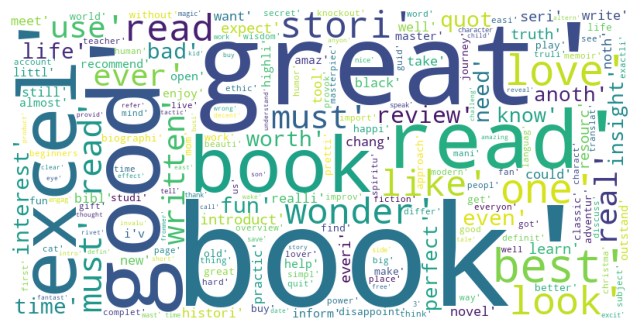

In [53]:
comment_words = str(' '.join(df_JB['review/summary']).split())

# word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comment_words)

# if you get font error, can try the following
# wordcloud = WordCloud(font_path='/path/to/your/font.ttf', width=800, height=400, 
# background_color='white').generate(sample_text)

plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
print('Word cloud for review/summary')
plt.show()

### This word cloud seems to have a lot of positive indicators that go into muliple subjects, we see words like great/good or excel, resource or stori. I think this indicates that most of these books have a postive light thatt span multiple genres and the summarys recomend the book typically in their summary.

Word cloud for review/text


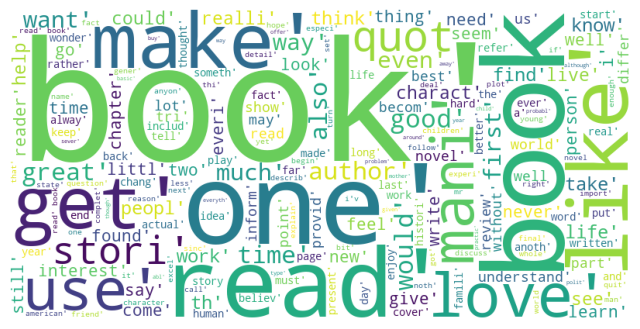

In [54]:
comment_words = str(' '.join(df_JB['review/text']).split())

# word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comment_words)

# if you get font error, can try the following
# wordcloud = WordCloud(font_path='/path/to/your/font.ttf', width=800, height=400, 
# background_color='white').generate(sample_text)

plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
print('Word cloud for review/text')
plt.show()

### Similar to the other one, we see a lot of postive indicators with words "like" and "love". We also see other words like "one", "make", "differ" which could indicate that there is only need for one of these books from the review, making a slightly negative disposition.

### **3. (8 pts) Perform text mining for each of the "review/summary" and "review/text" columns to estimate the similarity between documents. Show the similarity output tables for the first 5 documents for the summary and text columns. Paste the appropriate screenshots in the Word document.**

In [55]:
summary_corpus = [doc.split() for doc in df_JB["review/summary"]]
text_corpus = [doc.split() for doc in df_JB["review/text"]]

In [56]:
sum_dictionary = corpora.Dictionary(summary_corpus)
text_dictionary = corpora.Dictionary(text_corpus)

In [57]:
sum_dictionary.filter_extremes(no_below = 2, no_above = 0.75)
text_dictionary.filter_extremes(no_below = 2, no_above = 0.75)

In [58]:
sum_DFM = [sum_dictionary.doc2bow(doc) for doc in summary_corpus]
text_DFM = [text_dictionary.doc2bow(doc) for doc in text_corpus]

In [59]:
print('Summary')
print(sum_DFM)
print('Text')
print(text_DFM)

Summary
[[(0, 1)], [(1, 1)], [(2, 1), (3, 1)], [], [(4, 1)], [(5, 1)], [(6, 1), (7, 1)], [(7, 1), (8, 1), (9, 1)], [], [(3, 1), (10, 1), (11, 1), (12, 1)], [(13, 1), (14, 1), (15, 1), (16, 1)], [(17, 1), (18, 1)], [(9, 1), (19, 1), (20, 1)], [(21, 1)], [(7, 1), (22, 1), (23, 1)], [(24, 1), (25, 1)], [(26, 1), (27, 1)], [(15, 1), (28, 1), (29, 1)], [], [(20, 1)], [], [(27, 1), (30, 1), (31, 1)], [(23, 1)], [(20, 1), (32, 1)], [(7, 1), (33, 1), (34, 1)], [(20, 1), (35, 1)], [(17, 1), (27, 1)], [], [(17, 1), (36, 1), (37, 1)], [(33, 1), (38, 1)], [], [(39, 1)], [(27, 1), (40, 1), (41, 1)], [(42, 1), (43, 1)], [(3, 1), (44, 1)], [(37, 1), (45, 1)], [(46, 1), (47, 1), (48, 1)], [(49, 1), (50, 1)], [(51, 1), (52, 1), (53, 1)], [(54, 1)], [(55, 1)], [(7, 1), (27, 1)], [(20, 1), (23, 1), (56, 1)], [(11, 1), (57, 1)], [(17, 1), (58, 1), (59, 1)], [(20, 1), (29, 1)], [(60, 1)], [(27, 1)], [], [], [(61, 1), (62, 1)], [], [(60, 1)], [(17, 1), (20, 1)], [(63, 1), (64, 1)], [], [(20, 1), (65, 1), (6

In [60]:
print('Summary')
print('Number of documents:', len(sum_DFM))
print('Text')
print('Number of documents:', len(text_DFM))

Summary
Number of documents: 715
Text
Number of documents: 715


In [61]:
print('Summary')
print('Number of unique tokens:', len(sum_dictionary))
print('Text')
print('Number of unique tokens:', len(text_dictionary))

Summary
Number of unique tokens: 284
Text
Number of unique tokens: 4891


In [62]:
sum_simil = MatrixSimilarity(sum_DFM, num_features=len(sum_dictionary))
sum_distance = 1 - sum_simil[sum_DFM]

# convert simil to a data frame
sum_sim = pd.DataFrame(sum_simil[sum_DFM])
sum_sim[2]

0      0.0
1      0.0
2      1.0
3      0.0
4      0.0
      ... 
710    0.0
711    0.0
712    0.0
713    0.0
714    0.0
Name: 2, Length: 715, dtype: float32

In [63]:
simil = MatrixSimilarity(text_DFM, num_features=len(text_dictionary))
text_distance = 1 - simil[text_DFM]

# convert simil to a data frame
text_sim = pd.DataFrame(simil[text_DFM])
text_sim[2]

0      0.000000
1      0.035400
2      1.000000
3      0.067344
4      0.072602
         ...   
710    0.028820
711    0.000000
712    0.015082
713    0.037796
714    0.038576
Name: 2, Length: 715, dtype: float32

In [64]:
# train model
model = Word2Vec(text_corpus, min_count=1, workers=3, window=3, sg=0)

# most similar words to 'read'
model.wv.most_similar("read", topn=10)

[('book', 0.9959874153137207),
 ('also', 0.9946656823158264),
 ('one', 0.9946566224098206),
 ('like', 0.9944210052490234),
 ('good', 0.9940656423568726),
 ('mani', 0.9940420985221863),
 ('stori', 0.9940404295921326),
 ('way', 0.994006872177124),
 ('love', 0.9939913749694824),
 ('make', 0.9938519597053528)]

In [65]:
# train model
model = Word2Vec(summary_corpus, min_count=1, workers=3, window=3, sg=0)

# most similar words to 'read'
model.wv.most_similar("read", topn=10)

[('wrong', 0.2956947684288025),
 ('simplic', 0.29246458411216736),
 ('discoveri', 0.2848634719848633),
 ('favorit', 0.27275896072387695),
 ('fog', 0.26312869787216187),
 ('classroom...', 0.25980520248413086),
 ('eco-imperi', 0.2559402585029602),
 ('--', 0.2549530863761902),
 ('mayb', 0.23878468573093414),
 ('150', 0.23509161174297333)]

### **4. (10 pts) Perform topic modeling on “review/text” using LDA model and generate 6 topics. In the word document, show the topic model output for each of the 6 topics as the linear combination of the terms. For 2 of the topics, write a short description in 2-3 sentences for each topic.**

In [66]:
# Tokenize the documents in the Text column
corpus = [doc.split() for doc in df_JB["review/text"]]

# create DFM
import gensim
from gensim import corpora, models

# Create the term dictionary of the corpus
dictionary = corpora.Dictionary(corpus)

dictionary.filter_extremes(no_below = 2, no_above = 0.75)

# Convert the corpus into Document Term Matrix
DFM = [dictionary.doc2bow(doc) for doc in corpus]

In [67]:
n_topics = 6
ldamodel = models.LdaModel(DFM, num_topics=n_topics, id2word=dictionary, passes=40)

print(ldamodel.print_topics(num_topics=n_topics, num_words=10))

[(0, '0.007*"book" + 0.005*"present" + 0.004*"make" + 0.004*"cover" + 0.004*"great" + 0.004*"like" + 0.004*"academ" + 0.004*"modern" + 0.004*"well" + 0.004*"author"'), (1, '0.044*"book" + 0.009*"read" + 0.007*"love" + 0.007*"mani" + 0.006*"one" + 0.005*"make" + 0.005*"found" + 0.005*"would" + 0.005*"time" + 0.005*"much"'), (2, '0.024*"book" + 0.007*"would" + 0.007*"read" + 0.007*"one" + 0.006*"mani" + 0.005*"like" + 0.005*"work" + 0.005*"use" + 0.005*"learn" + 0.004*"get"'), (3, '0.015*"book" + 0.012*"read" + 0.010*"like" + 0.010*"stori" + 0.006*"one" + 0.006*"love" + 0.005*"get" + 0.005*"time" + 0.005*"make" + 0.004*"mani"'), (4, '0.022*"book" + 0.014*"read" + 0.007*"good" + 0.007*"one" + 0.007*"get" + 0.006*"like" + 0.006*"make" + 0.006*"want" + 0.005*"way" + 0.005*"book,"'), (5, '0.026*"book" + 0.011*"one" + 0.009*"read" + 0.005*"author" + 0.005*"like" + 0.004*"make" + 0.004*"great" + 0.004*"-" + 0.004*"charact" + 0.004*"also"')]


In [68]:
import pyLDAvis
pyLDAvis.enable_notebook()

import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(ldamodel, DFM, dictionary)
vis

c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\joblib\_utils.py:39

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.022771  0.024394       1        1  22.167001
5      0.014658  0.045640       2        1  21.521183
4      0.051204 -0.019877       3        1  18.097500
3      0.010050 -0.101375       4        1  17.735158
1      0.058399  0.041106       5        1  14.696425
0     -0.157083  0.010112       6        1   5.782733, topic_info=         Term         Freq        Total Category  logprob  loglift
2        book  1189.000000  1189.000000  Default  30.0000  30.0000
3       cover    56.000000    56.000000  Default  29.0000  29.0000
45    present    62.000000    62.000000  Default  28.0000  28.0000
1992   modern    34.000000    34.000000  Default  27.0000  27.0000
1735   cultur    38.000000    38.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
276       way     8.657062   147.307521   Topic6  -5.7799   0.0161
144     would     8.885005   223.421176   Topic6  -5.7539  -0.3744
13       also     8.283981   165.823432   Topic6  -5.8240  -0.1463
160   charact     8.013167   131.001128   Topic6  -5.8572   0.0562
326      show     7.030677    66.731258   Topic6  -5.9880   0.5999

[532 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1731      1  0.197777              "a
1731      2  0.197777              "a
1731      6  0.593330              "a
4792      6  0.810627  "intellectual"
2916      1  0.901469           &amp;
...     ...       ...             ...
699       4  0.339352           young
699       5  0.207382           young
3865      3  0.239894          young'
3865      6  0.479788          young'
4515      5  0.894064       yourself.

[1175 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 5, 4, 2, 1])

- Topic 1: Based on the saliency of the terms and topic 1 being the largest of all the other ones, it will encompass more of the words than any thing, with the most salient words having the top 30 most of which have postive indicators. I believe this is the best representive because the most sparse amount of words that go in the topic, taking about 25.8% of all the tokens created.
- Topic 6: I chose this one becuase its the opposite of topic one with the least amount of frequency of terms, only having 9.9% of tokens make up the topic. Looking at its relevance only, we can see that most words have a small amount in it, making it not as suggestive comapred to the others. 

### **5. (15 pts) Build predictive models for review/score, as follows:**

### **a. Apply SVD to extract 5 components from the “review/text” column.**

In [69]:
tfidf = models.TfidfModel(DFM)
DFM_tfidf = tfidf[DFM]

n_SVD = 5
SVD_model = models.LsiModel(DFM_tfidf, id2word=dictionary, num_topics=n_SVD)
SVD = SVD_model[DFM_tfidf]

# convert results into array
svd_array = gensim.matutils.corpus2csc(SVD).T.toarray()

# convert results to data frame
svd_df = pd.DataFrame(svd_array)

# show SVD results - reduced vector representation of the documents
svd_df

c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape

,0,1,2,3,4
0,0.070323,0.001639,-0.030497,0.006454,0.039734
1,0.191982,0.034270,0.003653,0.003372,0.074136
2,0.081498,0.114442,-0.069065,-0.027736,0.066619
3,0.170290,0.044930,0.086818,-0.034748,-0.000972
4,0.288977,-0.001632,-0.043027,-0.038080,0.029772
...,...,...,...,...,...
710,0.122726,0.091361,-0.092109,-0.020014,-0.044229
711,0.151025,-0.078914,0.029066,0.027380,-0.055522
712,0.159846,-0.033268,0.131283,0.000120,-0.016916
713,0.096547,-0.042569,0.092450,-0.146279,-0.029195


### **b. Combine two non-text columns with the 5 extracted components and build a decision tree model to predict the “review/score”. Call it Model-1.**

In [70]:
df_JB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 715 entries, 0 to 999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  715 non-null    object 
 1   Title               715 non-null    object 
 2   Price               715 non-null    float64
 3   User_id             715 non-null    object 
 4   profileName         715 non-null    object 
 5   review/helpfulness  715 non-null    float64
 6   review/score        715 non-null    int64  
 7   review/time         715 non-null    int64  
 8   review/summary      715 non-null    object 
 9   review/text         715 non-null    object 
 10  combined_text       715 non-null    object 
dtypes: float64(2), int64(2), object(7)
memory usage: 67.0+ KB


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Step 1: Create a new DataFrame with the combined columns
combined_df = pd.DataFrame({'Non-Text Column 1': df_JB['Price'], 'Non-Text Column 2': df_JB['review/helpfulness'], 
                            'Component 1': svd_df[0], 'Component 2': svd_df[1], 'Component 3': svd_df[2], 
                            'Component 4': svd_df[3], 'Component 5': svd_df[4]})

# Step 2: Split the data into input features (X) and target variable (y)
X = combined_df[['Non-Text Column 1', 'Non-Text Column 2', 'Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5']]
y = df_JB['review/score']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Adjust the number of samples in X and y to match
X = X[:715]
y = y[:715]

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Create an instance of the DecisionTreeClassifier model
model_1 = DecisionTreeClassifier()

# Step 5: Fit the model to the training data
model_1.fit(X_train, y_train)

# Step 6: Predict the target variable for the testing data
y_pred = model_1.predict(X_test)

# Step 7: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)


Shape of X: (924, 7)
Shape of y: (715,)


### **c. Report the confusion matrix of Model 1.**


Accuracy: 0.48951048951048953


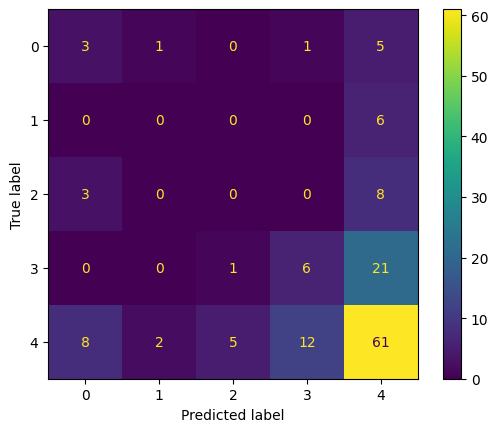

In [72]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Calculate the confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)
cm = metrics.confusion_matrix(y_test,y_pred) # row - true value; column - predicted
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()


### **d. Repeat tasks 5a-c with SVD to extract 8 components and build a predictive model. Call it Model-2. Report the confusion matrix of Model-2.**

In [73]:
tfidf = models.TfidfModel(DFM)
DFM_tfidf = tfidf[DFM]

n_SVD = 8
SVD_model = models.LsiModel(DFM_tfidf, id2word=dictionary, num_topics=n_SVD)
SVD = SVD_model[DFM_tfidf]

# convert results into array
svd_array = gensim.matutils.corpus2csc(SVD).T.toarray()

# convert results to data frame
svd_df = pd.DataFrame(svd_array)

# show SVD results - reduced vector representation of the documents
svd_df



c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\rbrul\Documents\GitHub\Advanced_BA\.venv\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape

,0,1,2,3,4,5,6,7
0,0.070417,0.011277,0.023037,0.032799,-0.034080,0.050168,0.012577,-0.055041
1,0.192024,0.031364,-0.000571,0.034415,-0.066804,-0.021182,0.104854,-0.132097
2,0.081820,0.110843,0.050710,-0.046826,-0.097499,0.007274,0.002122,0.016905
3,0.170375,0.038339,-0.092449,-0.038959,0.007731,0.012971,0.024383,0.014415
4,0.288980,0.010962,0.056000,-0.051280,-0.013874,-0.074746,0.037835,-0.052273
...,...,...,...,...,...,...,...,...
710,0.122547,0.106317,0.096914,-0.024659,0.065404,-0.003118,-0.063673,0.052182
711,0.151120,-0.084278,-0.041202,0.005944,0.051613,-0.033673,-0.015132,0.020203
712,0.159619,-0.025447,-0.131991,0.011702,-0.002954,0.100596,-0.030359,0.048705
713,0.096717,-0.047032,-0.079621,-0.124166,0.067793,-0.105440,0.071522,0.049617


In [74]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Step 1: Create a new DataFrame with the combined columns
combined_df = pd.DataFrame({'Non-Text Column 1': df_JB['Price'], 'Non-Text Column 2': df_JB['review/helpfulness'], 
                            'Component 1': svd_df[0], 'Component 2': svd_df[1], 'Component 3': svd_df[2], 
                            'Component 4': svd_df[3], 'Component 5': svd_df[4]})

# Step 2: Split the data into input features (X) and target variable (y)
X = combined_df[['Non-Text Column 1', 'Non-Text Column 2', 'Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5']]
y = df_JB['review/score']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Adjust the number of samples in X and y to match
X = X[:715]
y = y[:715]

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Create an instance of the DecisionTreeClassifier model
model_1 = DecisionTreeClassifier()

# Step 5: Fit the model to the training data
model_1.fit(X_train, y_train)

# Step 6: Predict the target variable for the testing data
y_pred = model_1.predict(X_test)

# Step 7: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)


Shape of X: (924, 7)
Shape of y: (715,)



Accuracy: 0.4965034965034965


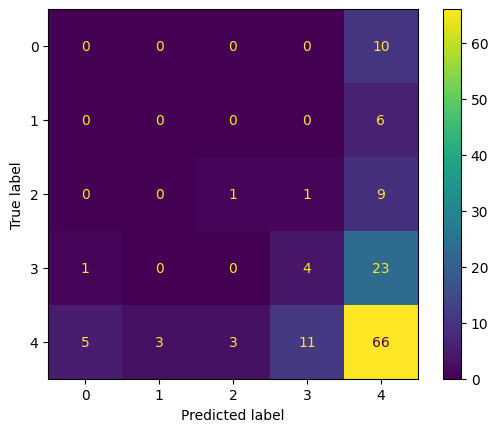

In [75]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Calculate the confusion matrix
accuracy = metrics.accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)
cm = metrics.confusion_matrix(y_test,y_pred) # row - true value; column - predicted
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()


### **e. Which model performs better?  Explain your answer.**

I would choose model 2 as most of time when ran with its predicted, it would spread to the other components rather than be consolidated into one. I look for the distribution among the labels and try to see which is more meaningful. If it would be for accuracy, then model 1 would be better but I think the second one gives more information. Both models are similar in nature though.